In [5]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Add path to misloc package
module_path = os.path.abspath(
    os.path.join(
        '..',
        '..',
        '..',
        '..',
        ))
sys.path.append(module_path)
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.optics import diffraction_int as diffi

In [6]:
## Matplotlib parameters
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
import scipy.optimize as opt

import scipy.io as sio

In [8]:
mat_images = sio.loadmat(
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "from_Biteen_group/high_SNR_nanosphere_experiments/mov_006_molecule_img_good.mat"
    )

Define data image coordinates

In [9]:
cm_per_nm = 1e-7

In [10]:
exp_obs_pts = diffi.observation_points(0, 48*20*cm_per_nm, 0, 48*20*cm_per_nm, 21) ## cm_per_m

### Try Gaussian fitting

In [11]:
class GaussianFittingTools(fit.FittingTools):
    """ Slightly modified FittingTools class for convenience in fitting real data
        I was motivated to write this beacuse I want the covarience for plotting fits"""
    
    def __init__(self, obs_pts):
        fit.FittingTools.__init__(self, obs_pts)
        
    def fit_gaussian(self, images):
        """ calculate index of maximum in each image. """
        num_of_images = images.shape[0]

        apparent_centroids_xy = np.zeros((num_of_images,2))

        max_positions = self.calculate_max_xy(images)
        print(max_positions)

        for i in np.arange(num_of_images):
            x0 = max_positions[0][i]
            y0 = max_positions[1][i]
            params0 = (1, x0, y0, 100, 100, 0,0)
            args=tuple(images[i]/np.max(images[i]))
            fit_results = opt.least_squares(self.misloc_data_minus_model, params0, args=args)
            resulting_fit_params = fit_results['x']
            
            resulting_gaussian_fit = self.twoD_Gaussian(
                (self.obs_points[1]/cm_per_nm, self.obs_points[2]/cm_per_nm), ## tuple of meshed (x,y) values
                *resulting_fit_params
                )

        return fit_results, resulting_gaussian_fit, params0


In [12]:
np.asarray([mat_images['bgsub_img'][...,26].ravel()]).shape

(1, 441)

In [13]:
## Run a test fit and get covarience
gauss_fit_inst = GaussianFittingTools(exp_obs_pts)
best_fit_params, best_fit, ini_guess_params = gauss_fit_inst.fit_gaussian(
    np.asarray([mat_images['bgsub_img'][...,26].ravel()]))

## Define hessian estimation and get covarience
hess = best_fit_params.jac.T @ best_fit_params.jac
cov = 2*np.linalg.inv(hess)

## Get image varience to correct normalized covarience
image26 = np.asarray([mat_images['bgsub_img'][...,26].ravel()])
data_var = np.std(image26/np.max(image26))**2
res_var = np.std(best_fit_params.fun)**2

## Print uncertainty matrix
unc = cov*res_var
with np.printoptions(precision=3, suppress=True):
    print(unc)

[array([480.]), array([528.])]
[[  0.002  -0.     -0.     -0.246  -0.263  -0.     -0.   ]
 [ -0.     99.974  -1.557  -0.002  -0.003   0.      0.   ]
 [ -0.     -1.557 113.184  -0.059  -0.05    0.      0.   ]
 [ -0.246  -0.002  -0.059 125.15   26.77   -0.003  -0.064]
 [ -0.263  -0.003  -0.05   26.77  141.689  -0.002  -0.067]
 [ -0.      0.      0.     -0.003  -0.002   0.631   0.   ]
 [ -0.      0.      0.     -0.064  -0.067   0.      0.   ]]


In [10]:
best_fit_params['x']

array([ 6.92816818e-01,  4.82265769e+02,  5.00226690e+02,  1.39403844e+02,
        1.48578338e+02, -1.15791514e-01,  5.93217962e-03])

In [11]:
ini_guess_params

(1, 480.00000000000006, 528.0, 100, 100, 0, 0)

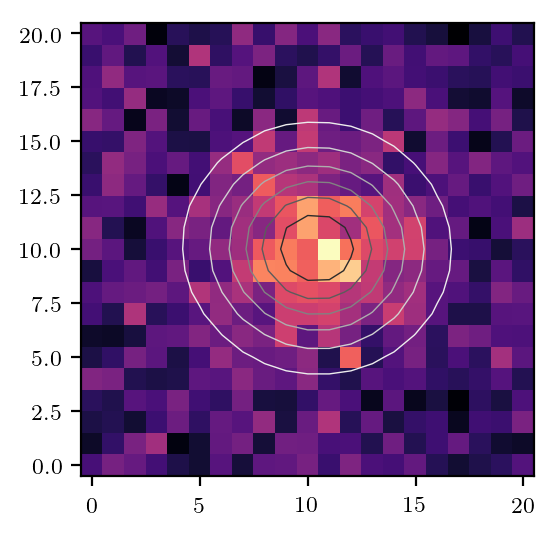

In [12]:
## Plot example image
image = mat_images['bgsub_img'][...,26].ravel()

plt.figure(
    figsize=(3,3), 
    dpi=200
) 
ax = plt.axes()

ax.imshow(image.reshape(21,21))

ax.contour(
    range(0,21),
    range(0,21),
    best_fit.reshape(exp_obs_pts[-2].shape),
    cmap='Greys',
    linewidths=0.5,
    )